# EDA for Moody PhysioNet Challenge

This notebook performs exploratory data analysis on the three ECG datasets used
for the Chagas-detection project. Each dataset has been converted to WFDB
format. We will validate the outputs, extract key metadata, explore label
distributions, and visualise sample ECG signals.

## CODE-15% Dataset 
This dataset contains approximately 300,000 ECGs from Brazil (2010–2016) with
self-reported Chagas labels. Each recording is 12-lead, 7.3 to 10.2 seconds,
sampled at 400 Hz.

https://zenodo.org/records/4916206

## SaMi-Trop Dataset

This dataset contains 1,631 ECGs from confirmed Chagas patients. Each recording
is 12-lead, 7.3 to 10.2 seconds, sampled at 400 Hz, with serologically validated
labels.

https://zenodo.org/records/4905618

## PTB-XL Dataset EDA

This dataset contains 21,799 ECGs from European patients, considered
Chagas-negative due to geographic region. Each recording is 12-lead, 10 seconds,
sampled at 500 Hz.

https://physionet.org/content/ptb-xl/1.0.3/

## Imports and setup

In [3]:
# Import libraries
import os
import wfdb
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, re

In [3]:
# CODE-15 %: load header files and inspect a few records
code15_dir = 'data/code15_output/exams_part0'              # folder with WFDB files
code15_hea_files = [f for f in os.listdir(code15_dir) if f.endswith('.hea')]

print(f'Found {len(code15_hea_files):,} .hea files (CODE-15 %)')
print('First 5 headers:', code15_hea_files[:5])

# Confirm label format in three random CODE-15 % records
for hea in random.sample(code15_hea_files, 3):
    rec_name = hea[:-4]                                     # strip ".hea"
    hdr = wfdb.rdheader(os.path.join(code15_dir, rec_name))
    
    print(f'\n--- {rec_name}.hea ---')
    for line in hdr.comments[:6]:
        print(line)

Found 19,901 .hea files (CODE-15 %)
First 5 headers: ['590673.hea', '214626.hea', '2936711.hea', '1175521.hea', '1073151.hea']

--- 1590543.hea ---
Age: 79
Sex: Female
Chagas label: False
Source: CODE-15%

--- 1649651.hea ---
Age: 68
Sex: Male
Chagas label: False
Source: CODE-15%

--- 1371488.hea ---
Age: 81
Sex: Male
Chagas label: True
Source: CODE-15%


In [ ]:
# PTB-XL: load header files and inspect a few records
ptbxl_dir = 'data/ptbxl_output'          # root folder with WFDB files
ptbxl_hea_files = []                     # collect all .hea paths

for root, _, files in os.walk(ptbxl_dir):
    ptbxl_hea_files.extend(
        os.path.join(root, f) for f in files if f.endswith('.hea')
    )

print(f'Found {len(ptbxl_hea_files):,} .hea files (PTB-XL)')
print('First 5 headers:',
      [os.path.basename(f) for f in ptbxl_hea_files[:5]])

# Confirm metadata format in three random PTB-XL records
for hea_path in random.sample(ptbxl_hea_files, 3):
    rec_path = hea_path[:-4]                         # strip ".hea"
    hdr = wfdb.rdheader(rec_path)

    rec_name = os.path.basename(rec_path)
    print(f'\n--- {rec_name}.hea ---')
    for line in hdr.comments[:6]:
        print(line)

Found 21,799 .hea files (PTB-XL)
First 5 headers: ['00001_hr.hea', '00002_hr.hea', '00003_hr.hea', '00004_hr.hea', '00005_hr.hea']

--- 10008_hr.hea ---
Age: 62
Sex: Female
Chagas label: False
Source: PTB-XL

--- 00085_hr.hea ---
Age: 17
Sex: Male
Chagas label: False
Source: PTB-XL

--- 06294_hr.hea ---
Age: 23
Sex: Male
Chagas label: False
Source: PTB-XL


In [8]:
# SaMi-Trop: load header files and inspect a few records
samitrop_dir = 'data/samitrop_output'                 # folder with WFDB files
samitrop_hea_files = [f for f in os.listdir(samitrop_dir) if f.endswith('.hea')]

print(f'Found {len(samitrop_hea_files):,} .hea files (SaMi-Trop)')
print('First 5 headers:', samitrop_hea_files[:5])

# Confirm label format in three random SaMi-Trop records
for hea in random.sample(samitrop_hea_files, 3):
    rec_name = hea[:-4]                               # strip '.hea'
    hdr = wfdb.rdheader(os.path.join(samitrop_dir, rec_name))

    print(f'\n--- {rec_name}.hea ---')
    for line in hdr.comments[:6]:
        print(line)

Found 1,631 .hea files (SaMi-Trop)
First 5 headers: ['294669.hea', '291318.hea', '247007.hea', '181629.hea', '250434.hea']

--- 267640.hea ---
Age: 64
Sex: Male
Chagas label: True
Source: SaMi-Trop

--- 448425.hea ---
Age: 61
Sex: Female
Chagas label: True
Source: SaMi-Trop

--- 340450.hea ---
Age: 55
Sex: Female
Chagas label: True
Source: SaMi-Trop


In [4]:
# Collect all record names (without the .hea extension)
record_names = [f[:-4] for f in os.listdir(data_dir) if f.endswith(".hea")]

# Function to extract the Chagas label from comments
def get_chagas_label(comments):
    """
    Return numeric label and the raw header line for inspection.
    """
    for line in comments:
        if 'Chagas label' in line:
            llow = line.lower()
            if 'true' in llow:
                return 1, line.strip()
            if 'false' in llow:
                return 0, line.strip()
    return None, None

# Sample three random records
for rec in random.sample(record_names, 3):
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    label_num, raw_line = get_chagas_label(hdr.comments)
    print(f"{rec} → {raw_line}  → numeric label = {label_num}")

2741927 → Chagas label: False  → numeric label = 0
548929 → Chagas label: False  → numeric label = 0
4392200 → Chagas label: False  → numeric label = 0


In [10]:
# Scan up to 2 000 records to find a 'True' label
found = None
for rec in record_names[:2000]:
    hdr = wfdb.rdheader(os.path.join(data_dir, rec))
    label_num, raw_line = get_chagas_label(hdr.comments)
    if label_num == 1:
        found = (rec, raw_line, label_num)
        break

if found:
    rec, raw_line, label_num = found
    print(f"{rec} → {raw_line}  → numeric label = {label_num}")
else:
    print("No positive (True) labels in first 2 000 records—data is heavily imbalanced.")


758600 → Chagas label: True  → numeric label = 1


In [11]:
# Build a DataFrame of record name + numeric Chagas label
sample_size = 5000            # keep small for a quick first run
records = []

for rec in record_names[:sample_size]:
    hdr         = wfdb.rdheader(os.path.join(data_dir, rec))
    label_num, _ = get_chagas_label(hdr.comments)
    records.append({'record': rec, 'label': label_num})

df = pd.DataFrame(records)
print(df.head())
print("\nLabel counts:\n", df['label'].value_counts(dropna=False))

    record  label
0   590673      0
1   214626      0
2  2936711      0
3  1175521      0
4  1073151      0

Label counts:
 label
0    4894
1     106
Name: count, dtype: int64


### Data preparation functions

In [12]:
def get_chagas_label(comments):
    """Extract Chagas label.
    Args: comments (list[str]) – header comment lines.
    Returns: (int|None, str|None) – numeric label 0/1 and raw line."""
    for line in comments:
        if 'Chagas label' in line:
            low = line.lower()
            if 'true' in low:  return 1, line.strip()
            if 'false' in low: return 0, line.strip()
    return None, None

def parse_age_sex(comments):
    """Extract age and sex.
    Args: comments (list[str]).
    Returns: (int|None, str|None) – age and sex."""
    age = sex = None
    for line in comments:
        if line.lower().startswith('age:'):
            m = re.search(r'\d+', line)
            age = int(m.group()) if m else None
        if line.lower().startswith('sex:'):
            sex = line.split(':')[-1].strip()
    return age, sex

In [ ]:
# CODE-15 % metadata table 

# Collect all record names
code15_records = [f[:-4] for f in os.listdir(code15_dir) if f.endswith('.hea')]

# Parse each header for label/age/sex and signal info
code15_rows = []
for rec in code15_records:
    hdr = wfdb.rdheader(os.path.join(code15_dir, rec))
    label, _ = get_chagas_label(hdr.comments)
    age, sex = parse_age_sex(hdr.comments)
    code15_rows.append({
        'record': rec,
        'label': label,
        'age': age,
        'sex': sex,
        'fs': hdr.fs,
        'length': hdr.sig_len,
        'path': f'{code15_dir}/{rec}',
        'source': 'CODE15'
    })

# Create DataFrame and save to disk
code15_meta = pd.DataFrame(code15_rows)
code15_meta.to_csv('code15_metadata_full.csv', index=False)
print(f'saved {code15_meta.shape[0]} rows to code15_metadata_full.csv')

saved 19901 rows to code15_metadata_full.csv


In [2]:
# Load the saved CODE-15% metadata CSV and show label counts
code15_meta = pd.read_csv('code15_metadata_full.csv')
print(code15_meta['label'].value_counts(dropna=False))

NameError: name 'pd' is not defined

In [ ]:
# Clinical annotations from exams.csv
csv_path = 'data/code15_input/exams.csv'
clinical = pd.read_csv(csv_path)

# Keep only columns you care about
keep_cols = ['exam_id', 'is_male', 'AF', 'RBBB', 'LBBB',
             'normal_ecg', 'death', 'timey']

clinical = clinical[keep_cols]

# Merge on exam_id and record
merged = code15_meta.merge(clinical, left_on='record', right_on='exam_id', how='left')
merged.drop(columns=['exam_id'], inplace=True)

# Save the merged DataFrame to a new CSV
merged.to_csv('code15_metadata_clinical.csv', index=False)
print('saved', merged.shape, 'to code15_metadata_clinical.csv')

saved (19901, 15) to code15_metadata_clinical.csv


In [4]:
# Load the saved metadata CSV and show label counts
code15_meta_clinical = pd.read_csv('code15_metadata_clinical.csv')
print(code15_meta_clinical['label'].value_counts(dropna=False))

code15_meta_clinical.head()

label
0    19499
1      402
Name: count, dtype: int64


,record,label,age,sex,fs,length,path,source,is_male,AF,RBBB,LBBB,normal_ecg,death,timey
0,590673,0,83,Male,400,4096,data/code15_output/exams_part0/590673,CODE15,True,False,False,False,True,NaN,NaN
1,214626,0,51,Female,400,4096,data/code15_output/exams_part0/214626,CODE15,False,False,False,False,True,False,4.167120
2,2936711,0,67,Female,400,2934,data/code15_output/exams_part0/2936711,CODE15,False,False,False,False,False,False,6.473967
3,1175521,0,58,Female,400,4096,data/code15_output/exams_part0/1175521,CODE15,False,False,False,False,True,False,2.084930
4,1073151,0,59,Male,400,4096,data/code15_output/exams_part0/1073151,CODE15,True,False,False,False,False,NaN,NaN


In [13]:
# SaMi-Trop metadata table 

# Collect all record names
samitrop_records = [f[:-4] for f in os.listdir(samitrop_dir) if f.endswith('.hea')]

# Parse each header for label/age/sex and signal info
samitrop_rows = []
for rec in samitrop_records:
    hdr = wfdb.rdheader(os.path.join(samitrop_dir, rec))
    label, _ = get_chagas_label(hdr.comments)
    age, sex = parse_age_sex(hdr.comments)
    samitrop_rows.append({
        'record': rec,
        'label': label,
        'age': age,
        'sex': sex,
        'fs': hdr.fs,
        'length': hdr.sig_len,
        'path': f'{samitrop_dir}/{rec}',
        'source': 'SAMITROP'
    })

# Create DataFrame and save to disk
samitrop_meta = pd.DataFrame(samitrop_rows)
samitrop_meta.to_csv('samitrop_metadata_full.csv', index=False)
print(f'saved {samitrop_meta.shape[0]} rows to samitrop_metadata_full.csv')


saved 1631 rows to samitrop_metadata_full.csv


In [16]:
# Load the saved SaMi-Trop metadata CSV and show label counts
samitrop_meta = pd.read_csv('samitrop_metadata_full.csv')   # reload saved table
print('SaMi-Trop label counts:\n', samitrop_meta['label'].value_counts(dropna=False))

SaMi-Trop label counts:
 label
1    1631
Name: count, dtype: int64


In [14]:
# PTB-XL metadata table 

# Collect all .hea file paths in the PTB-XL directory
ptbxl_hea_paths = [os.path.join(r, f)
                   for r, _, files in os.walk(ptbxl_dir)
                   for f in files if f.endswith('.hea')]

# Parse each header for label/age/sex and signal info
ptbxl_rows = []
for hea_path in ptbxl_hea_paths:
    rec_path = hea_path[:-4]                     # drop '.hea'
    rec_name = os.path.basename(rec_path)
    hdr = wfdb.rdheader(rec_path)
    label, _ = get_chagas_label(hdr.comments)    # expected 0 for all
    age, sex = parse_age_sex(hdr.comments)
    ptbxl_rows.append({
        'record': rec_name,
        'label': label,
        'age': age,
        'sex': sex,
        'fs': hdr.fs,
        'length': hdr.sig_len,
        'path': rec_path,
        'source': 'PTBXL'
    })

# Create DataFrame and save to disk
ptbxl_meta = pd.DataFrame(ptbxl_rows)
ptbxl_meta.to_csv('ptbxl_metadata_full.csv', index=False)
print(f'saved {ptbxl_meta.shape[0]} rows to ptbxl_metadata_full.csv')


saved 21799 rows to ptbxl_metadata_full.csv


In [17]:
# Load the saved PTB-XL metadata CSV and show label counts
ptbxl_meta = pd.read_csv('ptbxl_metadata_full.csv')   
print('PTB-XL label counts:\n', ptbxl_meta['label'].value_counts(dropna=False))

PTB-XL label counts:
 label
0    21799
Name: count, dtype: int64


## Demographic overview

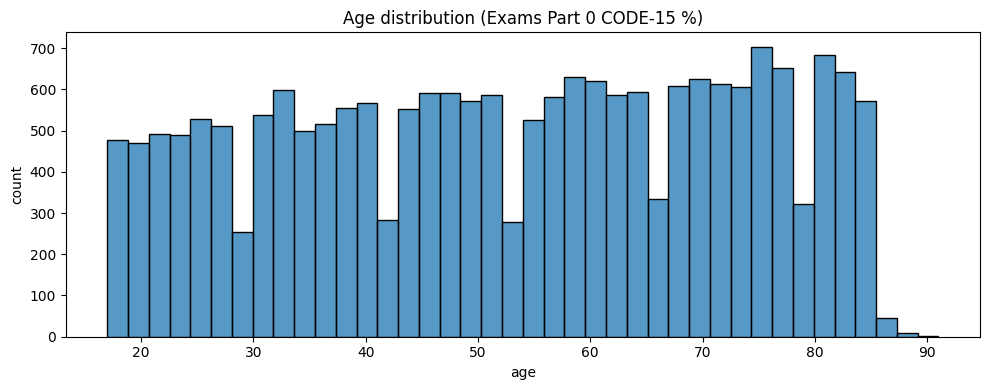

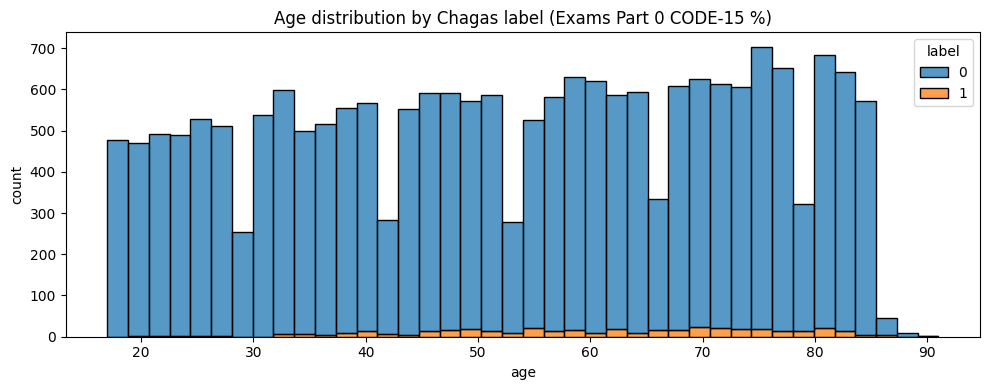

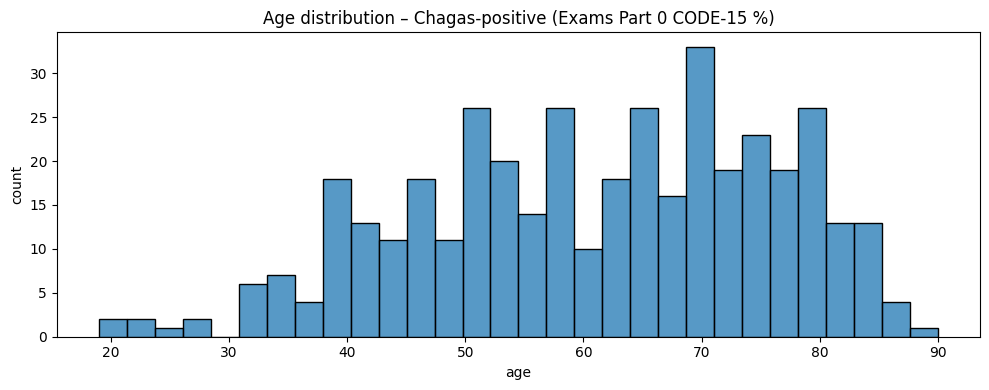

Overall age stats:
 count    19901.000000
mean        52.786493
std         19.784248
min         17.000000
25%         36.000000
50%         53.000000
75%         70.000000
max         91.000000
Name: age, dtype: float64 

Positive-class age stats:
 count    402.000000
mean      61.054726
std       14.870077
min       19.000000
25%       50.000000
50%       63.000000
75%       73.000000
max       90.000000
Name: age, dtype: float64 

Overall sex counts:
 sex
Female    12003
Male       7898
Name: count, dtype: int64 

Sex counts by label:
 label  sex   
0      Female    11736
       Male       7763
1      Female      267
       Male        135
Name: count, dtype: int64


In [20]:
# CODE-15 %: age and sex distributions
age_df = code15_meta_clinical.dropna(subset=['age'])

plt.figure(figsize=(10,4))
sns.histplot(age_df['age'], bins=40, kde=False)
plt.title('Age distribution (Exams Part 0 CODE-15 %)')
plt.xlabel('age'); plt.ylabel('count')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
sns.histplot(data=age_df, x='age', hue='label', bins=40,
             kde=False, multiple='stack')
plt.title('Age distribution by Chagas label (Exams Part 0 CODE-15 %)')
plt.xlabel('age'); plt.ylabel('count')
plt.tight_layout(); plt.show()

pos_df = age_df[age_df['label'] == 1]
plt.figure(figsize=(10,4))
sns.histplot(pos_df['age'], bins=30, kde=False)
plt.title('Age distribution – Chagas-positive (Exams Part 0 CODE-15 %)')
plt.xlabel('age'); plt.ylabel('count')
plt.tight_layout(); plt.show()

print('Overall age stats:\n', age_df['age'].describe(), '\n')
print('Positive-class age stats:\n', pos_df['age'].describe(), '\n')
print('Overall sex counts:\n', code15_meta_clinical['sex'].value_counts(dropna=False), '\n')
print('Sex counts by label:\n',
      code15_meta_clinical.groupby('label')['sex'].value_counts(dropna=False))


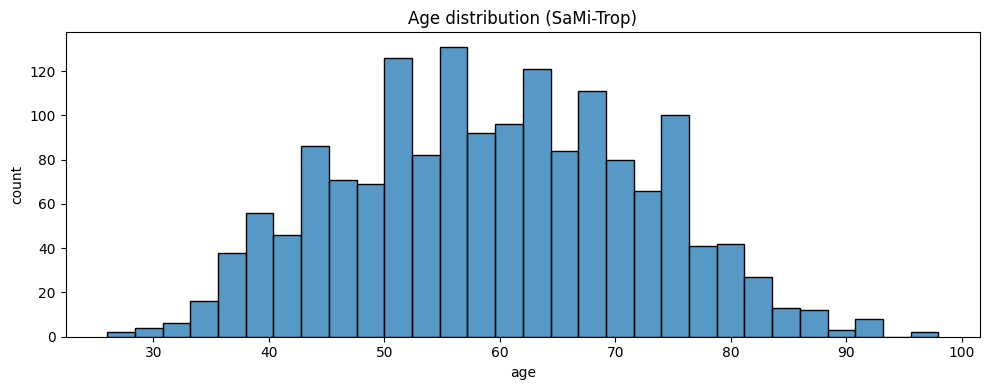

Age stats (SaMi-Trop):
 count    1631.000000
mean       59.397302
std        12.791258
min        26.000000
25%        50.000000
50%        59.000000
75%        69.000000
max        98.000000
Name: age, dtype: float64 

Sex counts (SaMi-Trop):
 sex
Female    1097
Male       534
Name: count, dtype: int64


In [21]:
# SaMi-Trop: age and sex distributions
age_df_st = samitrop_meta.dropna(subset=['age'])

plt.figure(figsize=(10,4))
sns.histplot(age_df_st['age'], bins=30, kde=False)
plt.title('Age distribution (SaMi-Trop)')
plt.xlabel('age'); plt.ylabel('count')
plt.tight_layout(); plt.show()

print('Age stats (SaMi-Trop):\n', age_df_st['age'].describe(), '\n')
print('Sex counts (SaMi-Trop):\n', samitrop_meta['sex'].value_counts(dropna=False))


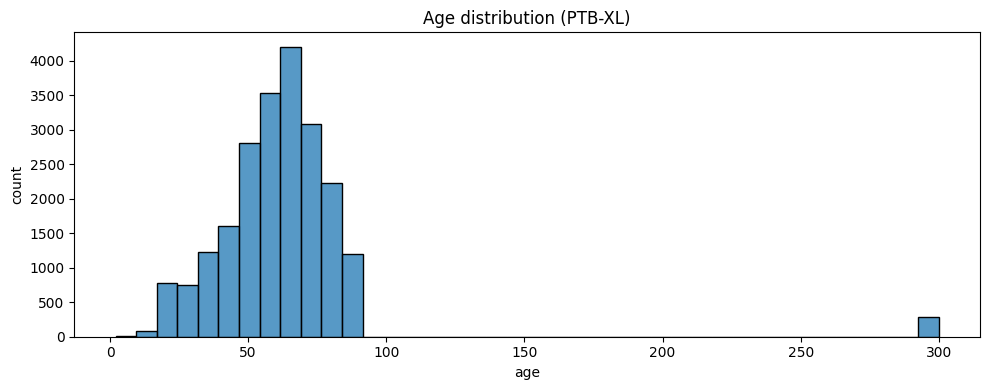

Age stats (PTB-XL):
 count    21799.000000
mean        62.769301
std         32.308813
min          2.000000
25%         50.000000
50%         62.000000
75%         72.000000
max        300.000000
Name: age, dtype: float64 

Sex counts (PTB-XL):
 sex
Male      11354
Female    10445
Name: count, dtype: int64


In [22]:
# PTB-XL: age and sex distributions
age_df_ptb = ptbxl_meta.dropna(subset=['age'])

plt.figure(figsize=(10,4))
sns.histplot(age_df_ptb['age'], bins=40, kde=False)
plt.title('Age distribution (PTB-XL)')
plt.xlabel('age'); plt.ylabel('count')
plt.tight_layout(); plt.show()

print('Age stats (PTB-XL):\n', age_df_ptb['age'].describe(), '\n')
print('Sex counts (PTB-XL):\n', ptbxl_meta['sex'].value_counts(dropna=False))


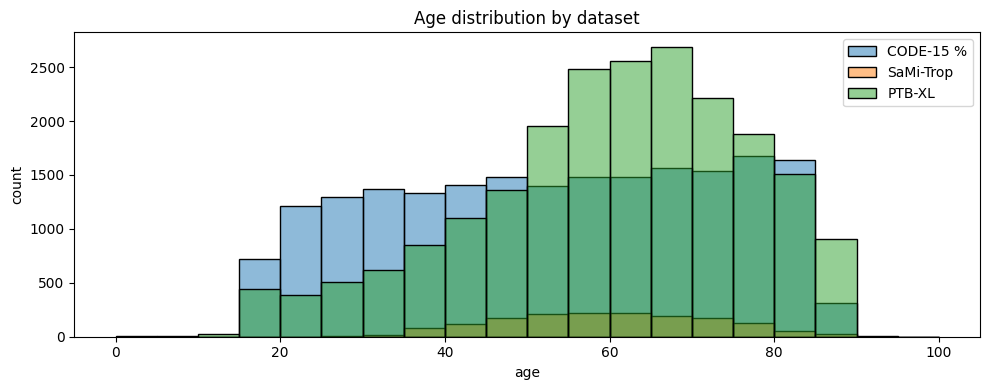

In [31]:
# Build a common 5-year bin grid for all three datasets
age_bins = np.arange(0, 101, 5)          # 0–100 in 5-year steps

plt.figure(figsize=(10,4))
sns.histplot(code15_meta_clinical['age'].dropna(),
             bins=age_bins, color='tab:blue',
             label='CODE-15 %', alpha=0.5, kde=False, stat='count')

sns.histplot(samitrop_meta['age'].dropna(),
             bins=age_bins, color='tab:orange',
             label='SaMi-Trop', alpha=0.5, kde=False, stat='count')

sns.histplot(ptbxl_meta['age'].dropna(),
             bins=age_bins, color='tab:green',
             label='PTB-XL',   alpha=0.5, kde=False, stat='count')

plt.title('Age distribution by dataset')
plt.xlabel('age'); plt.ylabel('count')
plt.legend(); plt.tight_layout(); plt.show()


## ECG signals overview

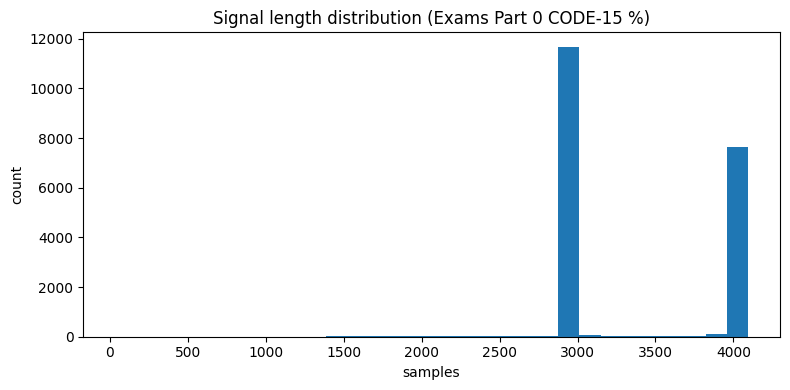

Length stats – CODE-15 %
 count    19901.000000
mean      3377.903522
std        582.677175
min         31.000000
25%       2934.000000
50%       2934.000000
75%       4096.000000
max       4096.000000
Name: length, dtype: float64


In [24]:
# CODE-15 %: signal-length distribution
lengths_code15 = code15_meta_clinical['length']

lengths_code15.plot.hist(bins=30, figsize=(8,4))
plt.title('Signal length distribution (Exams Part 0 CODE-15 %)')
plt.xlabel('samples'); plt.ylabel('count')
plt.tight_layout(); plt.show()

print('Length stats – CODE-15 %\n', lengths_code15.describe(percentiles=[0.25,0.5,0.75]))


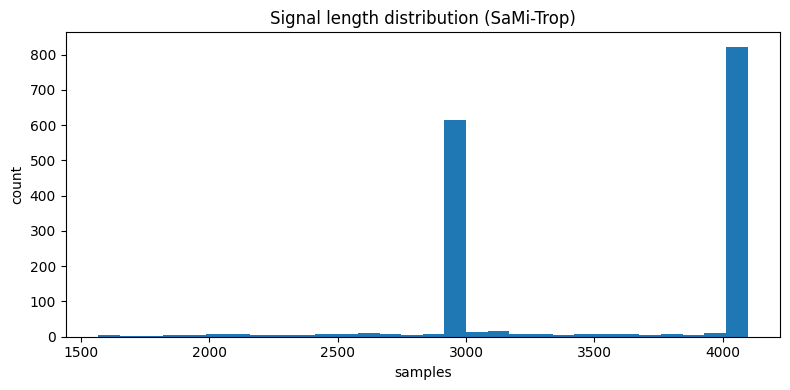

Length stats – SaMi-Trop
 count    1631.000000
mean     3516.529736
std       625.636175
min      1568.000000
25%      2934.000000
50%      4052.000000
75%      4096.000000
max      4096.000000
Name: length, dtype: float64


In [25]:
# SaMi-Trop: signal-length distribution
lengths_sami = samitrop_meta['length']

lengths_sami.plot.hist(bins=30, figsize=(8,4))
plt.title('Signal length distribution (SaMi-Trop)')
plt.xlabel('samples'); plt.ylabel('count')
plt.tight_layout(); plt.show()

print('Length stats – SaMi-Trop\n', lengths_sami.describe(percentiles=[0.25,0.5,0.75]))


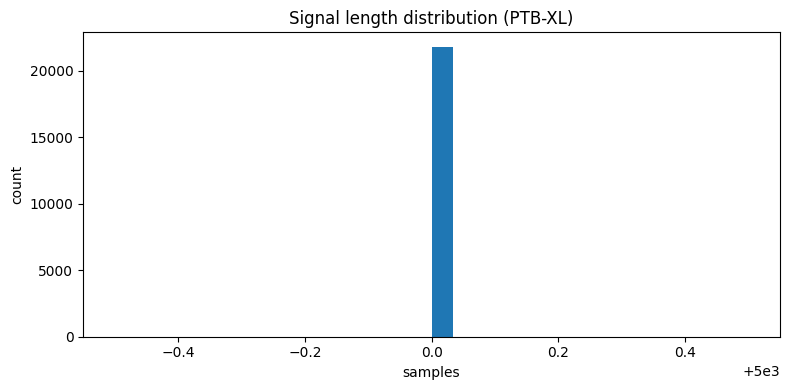

Length stats – PTB-XL
 count    21799.0
mean      5000.0
std          0.0
min       5000.0
25%       5000.0
50%       5000.0
75%       5000.0
max       5000.0
Name: length, dtype: float64


In [26]:
# PTB-XL: signal-length distribution
lengths_ptb = ptbxl_meta['length']

lengths_ptb.plot.hist(bins=30, figsize=(8,4))
plt.title('Signal length distribution (PTB-XL)')
plt.xlabel('samples'); plt.ylabel('count')
plt.tight_layout(); plt.show()

print('Length stats – PTB-XL\n', lengths_ptb.describe(percentiles=[0.25,0.5,0.75]))


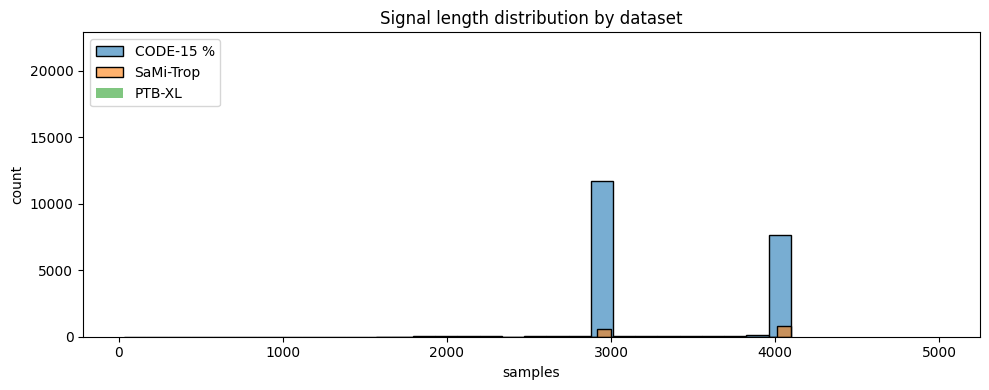

In [29]:
# Overlayed signal-length distributions for all three datasets
plt.figure(figsize=(10,4))
sns.histplot(lengths_code15, bins=30, color='tab:blue',
             label='CODE-15 %', alpha=0.6, kde=False)
sns.histplot(lengths_sami,  bins=30, color='tab:orange',
             label='SaMi-Trop', alpha=0.6, kde=False)
sns.histplot(lengths_ptb,   bins=30, color='tab:green',
             label='PTB-XL', alpha=0.6, kde=False)
plt.title('Signal length distribution by dataset')
plt.xlabel('samples'); plt.ylabel('count')
plt.legend(); plt.tight_layout(); plt.show()


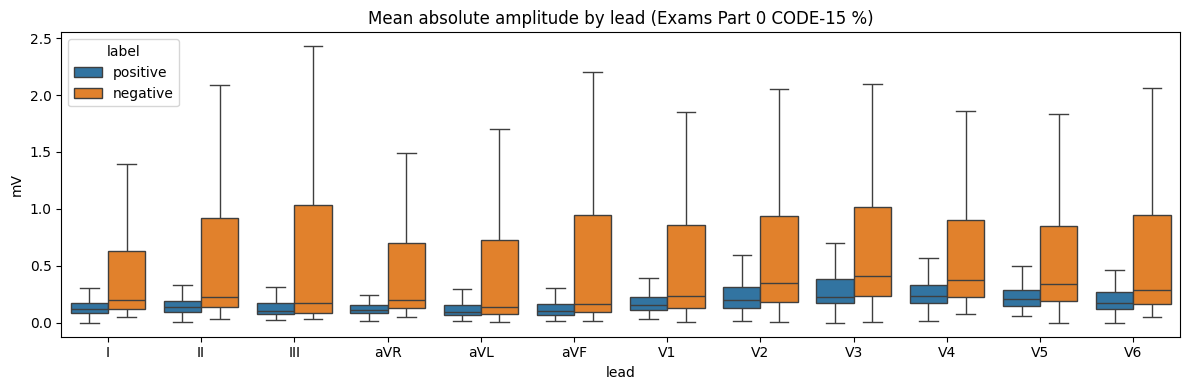

In [32]:
# Build amplitude table for CODE-15 %
pos_paths_c15 = code15_meta_clinical.loc[code15_meta_clinical['label']==1, 'path']
neg_paths_c15 = (code15_meta_clinical.loc[code15_meta_clinical['label']==0]
                 .sample(len(pos_paths_c15), random_state=0)['path'])

def lead_means_df(paths, label):
    rows = []
    for p in paths:
        sig = wfdb.rdrecord(p).p_signal
        m   = np.abs(sig).mean(axis=0)
        rows += [{'lead': i+1, 'amp': v, 'label': label} for i, v in enumerate(m)]
    return pd.DataFrame(rows)

df_amp_c15 = pd.concat([lead_means_df(pos_paths_c15, 'positive'),
                        lead_means_df(neg_paths_c15, 'negative')])

lead_names = ['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
df_amp_c15['lead'] = df_amp_c15['lead'].map(dict(enumerate(lead_names, 1)))

plt.figure(figsize=(12,4))
sns.boxplot(data=df_amp_c15, x='lead', y='amp', hue='label', showfliers=False)
plt.title('Mean absolute amplitude by lead (Exams Part 0 CODE-15 %)')
plt.xlabel('lead'); plt.ylabel('mV')
plt.tight_layout(); plt.show()


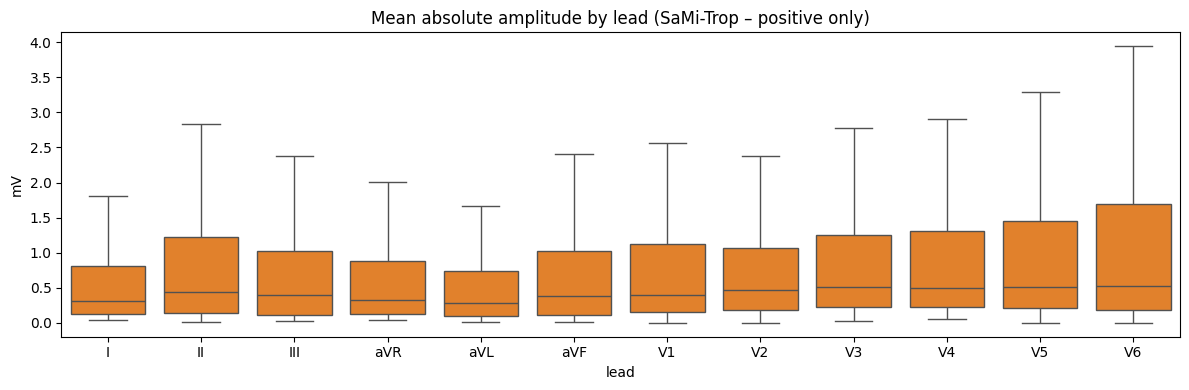

In [33]:
# All SaMi-Trop records are positive
sami_paths = samitrop_meta['path']

df_amp_sami = lead_means_df(sami_paths, 'positive')
df_amp_sami['lead'] = df_amp_sami['lead'].map(dict(enumerate(lead_names, 1)))

plt.figure(figsize=(12,4))
sns.boxplot(data=df_amp_sami, x='lead', y='amp', color='tab:orange', showfliers=False)
plt.title('Mean absolute amplitude by lead (SaMi-Trop – positive only)')
plt.xlabel('lead'); plt.ylabel('mV')
plt.tight_layout(); plt.show()

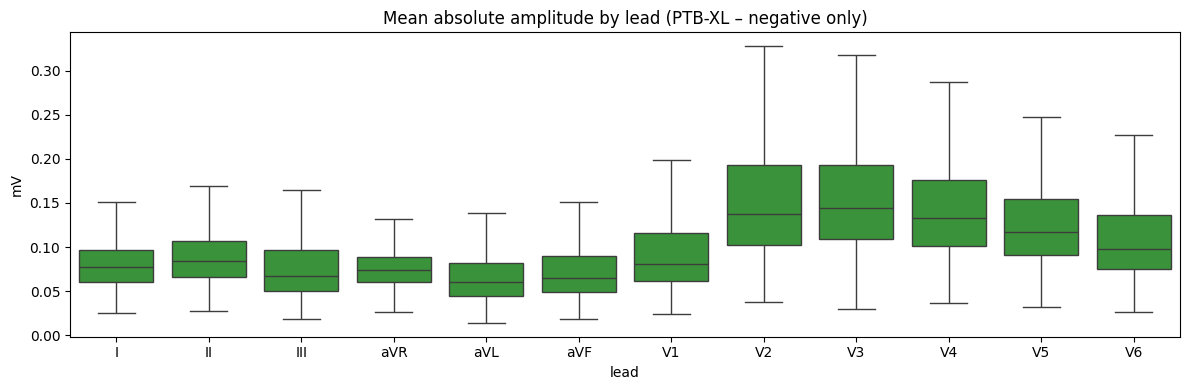

In [34]:
# All PTB-XL records are negative
ptb_paths = ptbxl_meta['path']

df_amp_ptb = lead_means_df(ptb_paths.sample(1000, random_state=0), 'negative')  # sample 1 000 to keep it light
df_amp_ptb['lead'] = df_amp_ptb['lead'].map(dict(enumerate(lead_names, 1)))

plt.figure(figsize=(12,4))
sns.boxplot(data=df_amp_ptb, x='lead', y='amp', color='tab:green', showfliers=False)
plt.title('Mean absolute amplitude by lead (PTB-XL – negative only)')
plt.xlabel('lead'); plt.ylabel('mV')
plt.tight_layout(); plt.show()


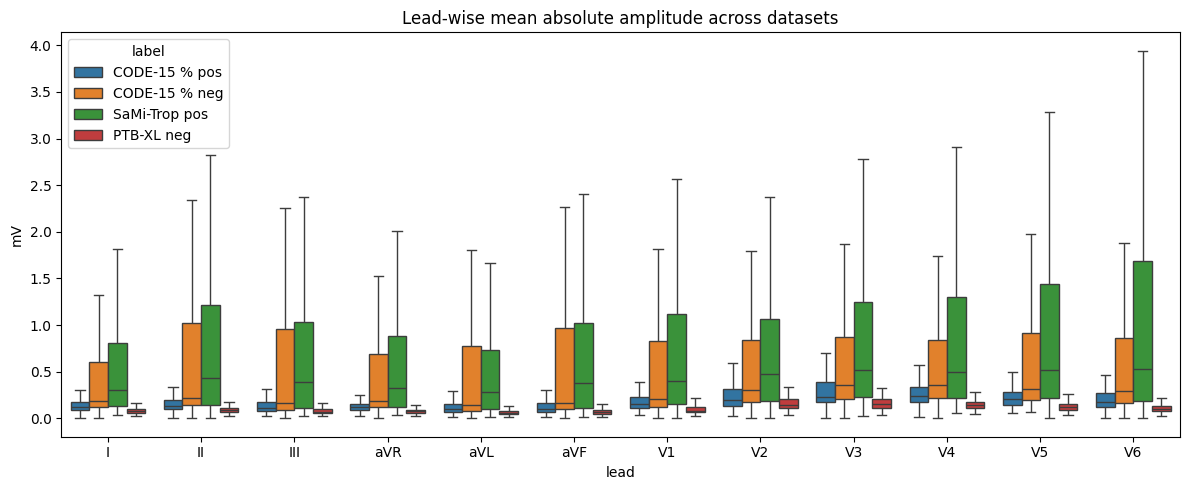

In [35]:
# Combine one positive set (SaMi-Trop) and two negative sets (CODE-15 % sample, PTB-XL sample)
neg_paths_c15_all = code15_meta_clinical.loc[code15_meta_clinical['label']==0, 'path']
neg_paths_ptb_sample = ptb_paths.sample(500, random_state=1)

df_overlay = pd.concat([
    lead_means_df(pos_paths_c15, 'CODE-15 % pos'),
    lead_means_df(neg_paths_c15_all.sample(500, random_state=1), 'CODE-15 % neg'),
    lead_means_df(sami_paths, 'SaMi-Trop pos'),
    lead_means_df(neg_paths_ptb_sample, 'PTB-XL neg')
])
df_overlay['lead'] = df_overlay['lead'].map(dict(enumerate(lead_names, 1)))

plt.figure(figsize=(12,5))
sns.boxplot(data=df_overlay, x='lead', y='amp', hue='label', showfliers=False)
plt.title('Lead-wise mean absolute amplitude across datasets')
plt.xlabel('lead'); plt.ylabel('mV')
plt.tight_layout(); plt.show()


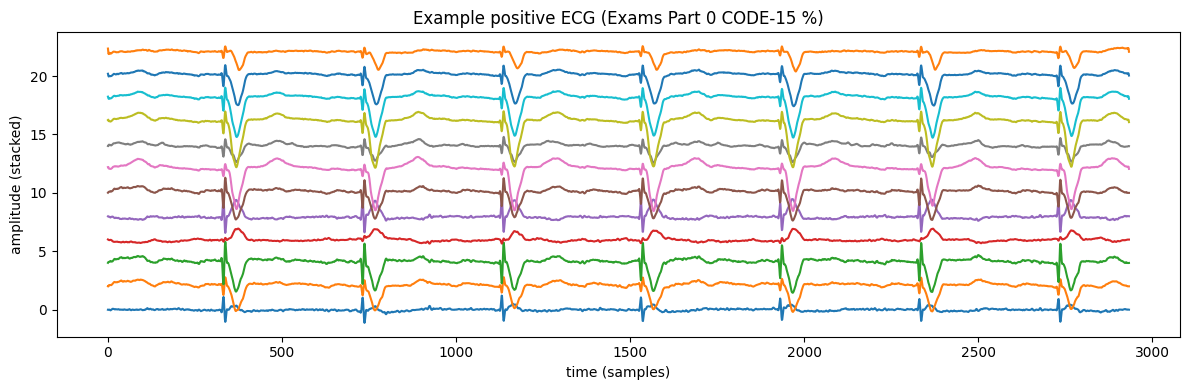

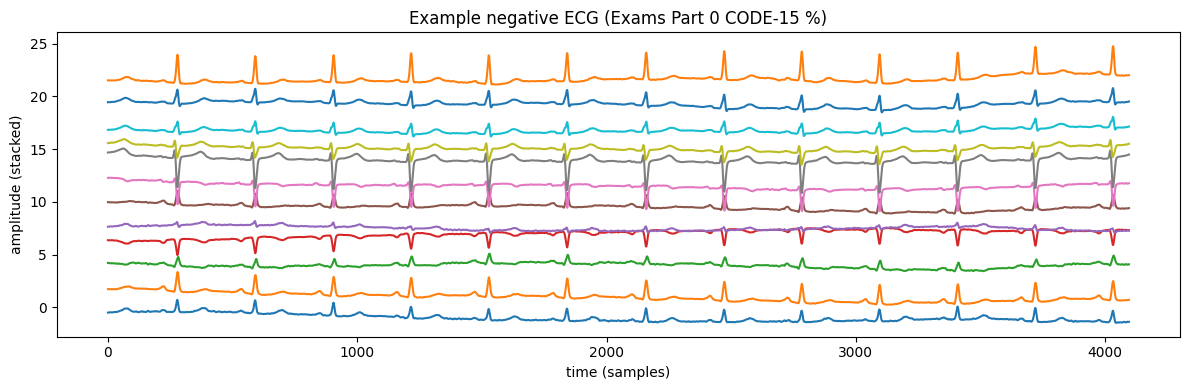

In [ ]:
# Plot example ECG records – one positive and one negative
def plot_record(path, title):
    rec = wfdb.rdrecord(path)
    sig = rec.p_signal
    plt.figure(figsize=(12,4))
    for i in range(12):
        plt.plot(sig[:, i] + i*2)
    plt.title(title); plt.xlabel('time (samples)'); plt.ylabel('amplitude (stacked)')
    plt.tight_layout(); plt.show()

# one positive, one negative
pos_path = code15_meta_clinical.loc[code15_meta_clinical['label']==1, 'path'].iloc[0]
neg_path = code15_meta_clinical.loc[code15_meta_clinical['label']==0, 'path'].iloc[0]

plot_record(pos_path, 'Example positive ECG (Exams Part 0 CODE-15 %)')
plot_record(neg_path, 'Example negative ECG (Exams Part 0 CODE-15 %)')


## Clinical flag overview


Clinical flags correlation matrix:
                   AF      RBBB      LBBB  normal_ecg     death
AF          1.000000  0.057928  0.064709   -0.119929  0.110255
RBBB        0.057928  1.000000 -0.011837   -0.130683  0.037036
LBBB        0.064709 -0.011837  1.000000   -0.104040  0.036462
normal_ecg -0.119929 -0.130683 -0.104040    1.000000 -0.073000
death       0.110255  0.037036  0.036462   -0.073000  1.000000 



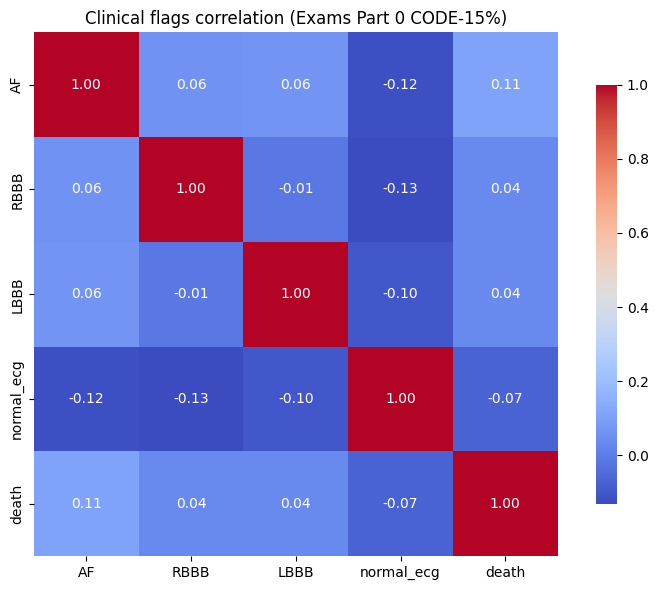

In [7]:
# Clinical flags to include
flag_cols = ['AF', 'RBBB', 'LBBB', 'normal_ecg', 'death']

# Fill NaNs with 0 and convert to int for correlation
flag_corr = (code15_meta_clinical[flag_cols]
             .fillna(0)
             .astype(int)
             .corr())

# Print the correlation matrix
print('Clinical flags correlation matrix:\n', flag_corr, '\n')

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(flag_corr,
            annot=True, fmt='.2f',
            cmap='coolwarm', square=True,
            cbar_kws={'shrink': .8})
plt.title('Clinical flags correlation (Exams Part 0 CODE-15%)')
plt.tight_layout()
plt.show()


           AF  RBBB  LBBB  normal_ecg
negative  416   443   324        7637
positive   28    82    12          57 



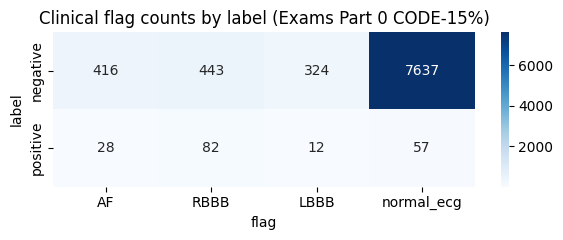

In [ ]:
flag_cols = ['AF', 'RBBB', 'LBBB', 'normal_ecg']

# Count how many records have each flag, by label
flag_counts = code15_meta_clinical.groupby('label')[flag_cols].sum()


